<a href="https://colab.research.google.com/github/Arifanalysis/Fabric-class/blob/main/fine_tune_rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import torch
import pandas as pd
import cv2
from PIL import Image
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as T

# ---------------------------------------
# 0. Label Mapping and Config
# ---------------------------------------
label_mapping = {
    "stain": 1,
    "hole": 2,
    "cut": 3,
    "broken thread": 4
}
num_classes = len(label_mapping) + 1

csv_path = "/content/labels_my-project-name_2025-02-27-11-52-06.csv"  # ✅ Update
img_dir = "/content/drive/MyDrive/val"                             # ✅ Update
pretrained_model_path = "/content/fabric_defect_detector5.pth"        # ✅ Update
save_path = "/content/fabric_defect_detector_finetuned.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# ---------------------------------------
# 1. Dataset Class
# ---------------------------------------
class FabricDefectDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.annotations['label_name'] = self.annotations['label_name'].replace({
            "holes": "hole", "cuts": "cut", "stains": "stain", "broken threads": "broken thread"
        })
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations['image_name'].unique())

    def __getitem__(self, idx):
        image_name = self.annotations['image_name'].unique()[idx]
        image_path = os.path.join(self.img_dir, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        records = self.annotations[self.annotations['image_name'] == image_name]

        boxes, labels = [], []
        for _, row in records.iterrows():
            x_min, y_min = row['bbox_x'], row['bbox_y']
            x_max = x_min + row['bbox_width']
            y_max = y_min + row['bbox_height']
            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(label_mapping[row['label_name']])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image = T.ToTensor()(image)

        return image, {"boxes": boxes, "labels": labels}

# ---------------------------------------
# 2. DataLoader
# ---------------------------------------
dataset = FabricDefectDataset(csv_path, img_dir)
data_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# ---------------------------------------
# 3. Model Loader + Fine-Tuning Setup
# ---------------------------------------
def load_model(path):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Force load on CPU to avoid GPU-related error
    state_dict = torch.load(path, map_location=torch.device('cpu'), weights_only=False)
    model.load_state_dict(state_dict)
    return model.to(device)



model = load_model(pretrained_model_path)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# ---------------------------------------
# 4. Training Loop
# ---------------------------------------
num_epochs = 5
for epoch in range(num_epochs):
    total_loss = 0.0
    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        total_loss += losses.item()

    print(f"📦 Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")

# ---------------------------------------
# 5. Save Model
# ---------------------------------------
torch.save(model.state_dict(), save_path)
if os.path.exists(save_path):
    print(f"✅ Fine-tuned model saved to: {save_path}")
else:
    print("❌ Model saving failed!")

# ---------------------------------------
# 6. Reload & Confirm
# ---------------------------------------
try:
    reloaded_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)
    in_features = reloaded_model.roi_heads.box_predictor.cls_score.in_features
    reloaded_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    reloaded_model.load_state_dict(torch.load(save_path))
    reloaded_model.to(device)
    reloaded_model.eval()
    print("✅ Fine-tuned model reloaded successfully.")
except Exception as e:
    print(f"❌ Error reloading model: {e}")


✅ Using device: cpu


TypeError: Expected state_dict to be dict-like, got <class 'torchvision.models.detection.faster_rcnn.FasterRCNN'>.

In [9]:
import os
import torch
import pandas as pd
import cv2
from PIL import Image
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN
import torchvision.transforms as T
import torch.serialization

# ---------------------------------------
# Label Mapping
# ---------------------------------------
label_mapping = {
    "stain": 1,
    "hole": 2,
    "cut": 3,
    "broken thread": 4
}
num_classes = len(label_mapping) + 1

# ---------------------------------------
# Device
# ---------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# ---------------------------------------
# Dataset
# ---------------------------------------
class FabricDefectDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.annotations['label_name'] = self.annotations['label_name'].replace({
            "holes": "hole", "cuts": "cut",
            "stains": "stain", "broken threads": "broken thread"
        })
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations['image_name'].unique())

    def __getitem__(self, idx):
        image_name = self.annotations['image_name'].unique()[idx]
        image_path = os.path.join(self.img_dir, image_name)
        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"Image not found or can't be opened: {image_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        image = Image.fromarray(image)

        records = self.annotations[self.annotations['image_name'] == image_name]
        boxes, labels = [], []
        for _, row in records.iterrows():
            x_min, y_min = row['bbox_x'], row['bbox_y']
            x_max = x_min + row['bbox_width']
            y_max = y_min + row['bbox_height']
            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(label_mapping[row['label_name']])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image = T.ToTensor()(image)

        target = { "boxes": boxes, "labels": labels }
        return image, target

# ---------------------------------------
# Load Dataset
# ---------------------------------------
csv_path = "/content/labels_my-project-name_2025-02-27-11-52-06.csv"
img_dir = "/content/drive/MyDrive/val"
dataset = FabricDefectDataset(csv_path, img_dir)
data_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# ---------------------------------------
# Load Pretrained Model Safely
# ---------------------------------------
pretrained_model_path = "/content/fabric_defect_detector5.pth"

print("🔁 Loading saved model...")

# 🔒 Allow full model deserialization for FasterRCNN in PyTorch 2.6+
torch.serialization.add_safe_globals([FasterRCNN])

# ✅ Load the complete model
model = torch.load(pretrained_model_path, map_location=device, weights_only=False)
model.to(device)
model.train()

# ---------------------------------------
# Optimizer
# ---------------------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# ---------------------------------------
# Fine-Tuning
# ---------------------------------------
num_epochs = 5
best_loss = float('inf')
best_model_path = "/content/fabric_defect_detector_finetuned_best.pth"

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        losses.backward()
        optimizer.step()
        epoch_loss += losses.item()

    print(f"📦 Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(model, best_model_path)
        print(f"✅ Best model saved at epoch {epoch+1} with loss {best_loss:.4f}")

# ---------------------------------------
# Confirm File Exists & Reload
# ---------------------------------------
if os.path.exists(best_model_path):
    print(f"📁 Model saved successfully: {best_model_path}")
    reloaded_model = torch.load(best_model_path, map_location=device, weights_only=False)
    print("✅ Reloaded model successfully!")
else:
    print("❌ Model file not found.")


✅ Using device: cpu
🔁 Loading saved model...


FileNotFoundError: Image not found or can't be opened: /content/drive/MyDrive/val/IMG20250221115336.jpg

In [10]:
import os
import torch
import pandas as pd
import cv2
from PIL import Image
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as T
import torch.serialization
from torchvision.models.detection import FasterRCNN

# ---------------------------------------
# Allow loading the FasterRCNN model
# ---------------------------------------
torch.serialization.add_safe_globals([FasterRCNN])

# ---------------------------------------
# Label Mapping
# ---------------------------------------
label_mapping = {
    "stain": 1,
    "hole": 2,
    "cut": 3,
    "broken thread": 4
}
num_classes = len(label_mapping) + 1

# ---------------------------------------
# Device
# ---------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# ---------------------------------------
# Dataset
# ---------------------------------------
class FabricDefectDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.annotations['label_name'] = self.annotations['label_name'].replace({
            "holes": "hole", "cuts": "cut",
            "stains": "stain", "broken threads": "broken thread"
        })
        self.img_dir = img_dir
        self.transform = transform

        # Filter out image entries with missing files
        self.valid_images = []
        for img_name in self.annotations['image_name'].unique():
            img_path = os.path.join(self.img_dir, img_name)
            if os.path.exists(img_path):
                self.valid_images.append(img_name)
            else:
                print(f"⚠️ Skipping missing image: {img_path}")

    def __len__(self):
        return len(self.valid_images)

    def __getitem__(self, idx):
        image_name = self.valid_images[idx]
        image_path = os.path.join(self.img_dir, image_name)
        image = cv2.imread(image_path)
        if image is None:
            print(f"⚠️ Image failed to load: {image_path}")
            return self.__getitem__((idx + 1) % len(self))  # Try next image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)

        records = self.annotations[self.annotations['image_name'] == image_name]
        boxes, labels = [], []
        for _, row in records.iterrows():
            x_min, y_min = row['bbox_x'], row['bbox_y']
            x_max = x_min + row['bbox_width']
            y_max = y_min + row['bbox_height']
            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(label_mapping[row['label_name']])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image = T.ToTensor()(image)

        target = { "boxes": boxes, "labels": labels }
        return image, target

# ---------------------------------------
# Load Dataset
# ---------------------------------------
csv_path = "/content/labels_my-project-name_2025-02-27-11-52-06.csv"
img_dir = "/content/drive/MyDrive/val"
dataset = FabricDefectDataset(csv_path, img_dir)
data_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# ---------------------------------------
# Load Pretrained Model
# ---------------------------------------
pretrained_model_path = "/content/fabric_defect_detector5.pth"

print("🔁 Loading saved model...")
model = torch.load(pretrained_model_path, map_location=device, weights_only=False)
model.to(device)
model.train()

# ---------------------------------------
# Optimizer
# ---------------------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# ---------------------------------------
# Fine-Tuning
# ---------------------------------------
num_epochs = 5
best_loss = float('inf')
best_model_path = "/content/fabric_defect_detector_finetuned_best.pth"

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        losses.backward()
        optimizer.step()
        epoch_loss += losses.item()

    print(f"📦 Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(model, best_model_path)
        print(f"✅ Best model saved at epoch {epoch+1} with loss {best_loss:.4f}")

# ---------------------------------------
# Confirm File Exists & Reload
# ---------------------------------------
if os.path.exists(best_model_path):
    print(f"📁 Model saved successfully: {best_model_path}")
    reloaded_model = torch.load(best_model_path, map_location=device)
    print("✅ Reloaded model successfully!")
else:
    print("❌ Model file not found.")


✅ Using device: cpu
⚠️ Skipping missing image: /content/drive/MyDrive/val/IMG20250221111614.jpg
⚠️ Skipping missing image: /content/drive/MyDrive/val/IMG20250221115336.jpg
🔁 Loading saved model...
📦 Epoch [1/5], Loss: 6.4694
✅ Best model saved at epoch 1 with loss 6.4694
📦 Epoch [2/5], Loss: 5.9639
✅ Best model saved at epoch 2 with loss 5.9639
📦 Epoch [3/5], Loss: 5.1563
✅ Best model saved at epoch 3 with loss 5.1563
📦 Epoch [4/5], Loss: 4.2221
✅ Best model saved at epoch 4 with loss 4.2221
📦 Epoch [5/5], Loss: 4.2622
📁 Model saved successfully: /content/fabric_defect_detector_finetuned_best.pth


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL torchvision.models.detection.transform.GeneralizedRCNNTransform was not an allowed global by default. Please use `torch.serialization.add_safe_globals([GeneralizedRCNNTransform])` or the `torch.serialization.safe_globals([GeneralizedRCNNTransform])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [11]:
import os
import torch
import pandas as pd
import cv2
from PIL import Image
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as T
import torch.serialization
from torchvision.models.detection.transform import GeneralizedRCNNTransform

# ---------------------------------------
# Label Mapping
# ---------------------------------------
label_mapping = {
    "stain": 1,
    "hole": 2,
    "cut": 3,
    "broken thread": 4
}
num_classes = len(label_mapping) + 1

# ---------------------------------------
# Device
# ---------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# ---------------------------------------
# Dataset
# ---------------------------------------
class FabricDefectDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.annotations['label_name'] = self.annotations['label_name'].replace({
            "holes": "hole", "cuts": "cut",
            "stains": "stain", "broken threads": "broken thread"
        })
        self.img_dir = img_dir
        self.transform = transform
        self.valid_indices = self._filter_valid_indices()

    def _filter_valid_indices(self):
        valid_indices = []
        for idx, image_name in enumerate(self.annotations['image_name'].unique()):
            image_path = os.path.join(self.img_dir, image_name)
            if os.path.exists(image_path):
                valid_indices.append(idx)
            else:
                print(f"⚠️ Skipping missing image: {image_path}")
        return valid_indices

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        image_idx = self.valid_indices[idx]
        image_name = self.annotations['image_name'].unique()[image_idx]
        image_path = os.path.join(self.img_dir, image_name)
        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"Image not found or can't be opened: {image_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)

        records = self.annotations[self.annotations['image_name'] == image_name]
        boxes, labels = [], []
        for _, row in records.iterrows():
            x_min, y_min = row['bbox_x'], row['bbox_y']
            x_max = x_min + row['bbox_width']
            y_max = y_min + row['bbox_height']
            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(label_mapping[row['label_name']])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image = T.ToTensor()(image)

        target = {"boxes": boxes, "labels": labels}
        return image, target

# ---------------------------------------
# Load Dataset
# ---------------------------------------
csv_path = "/content/labels_my-project-name_2025-02-27-11-52-06.csv"
img_dir = "/content/drive/MyDrive/val"
dataset = FabricDefectDataset(csv_path, img_dir)
data_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# ---------------------------------------
# Safe Global Registration
# ---------------------------------------
torch.serialization.add_safe_globals([FasterRCNN, GeneralizedRCNNTransform])

# ---------------------------------------
# Load Pretrained Model
# ---------------------------------------
pretrained_model_path = "/content/fabric_defect_detector5.pth"
print("🔁 Loading saved model...")
model = torch.load(pretrained_model_path, map_location=device, weights_only=False)
model.to(device)
model.train()

# ---------------------------------------
# Optimizer
# ---------------------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# ---------------------------------------
# Fine-Tuning
# ---------------------------------------
num_epochs = 5
best_loss = float('inf')
best_model_path = "/content/fabric_defect_detector_finetuned_best1.pth"

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        losses.backward()
        optimizer.step()
        epoch_loss += losses.item()

    print(f"📦 Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(model, best_model_path)
        print(f"✅ Best model saved at epoch {epoch+1} with loss {best_loss:.4f}")

# ---------------------------------------
# Confirm File Exists & Reload
# ---------------------------------------
if os.path.exists(best_model_path):
    print(f"📁 Model saved successfully: {best_model_path}")
    reloaded_model = torch.load(best_model_path, map_location=device, weights_only=False)
    print("✅ Reloaded model successfully!")
else:
    print("❌ Model file not found.")


✅ Using device: cpu
⚠️ Skipping missing image: /content/drive/MyDrive/val/IMG20250221111614.jpg
⚠️ Skipping missing image: /content/drive/MyDrive/val/IMG20250221115336.jpg
🔁 Loading saved model...
📦 Epoch [1/5], Loss: 6.4453
✅ Best model saved at epoch 1 with loss 6.4453
📦 Epoch [2/5], Loss: 5.9486
✅ Best model saved at epoch 2 with loss 5.9486
📦 Epoch [3/5], Loss: 5.0140
✅ Best model saved at epoch 3 with loss 5.0140
📦 Epoch [4/5], Loss: 4.1974
✅ Best model saved at epoch 4 with loss 4.1974
📦 Epoch [5/5], Loss: 3.5033
✅ Best model saved at epoch 5 with loss 3.5033
📁 Model saved successfully: /content/fabric_defect_detector_finetuned_best.pth
✅ Reloaded model successfully!


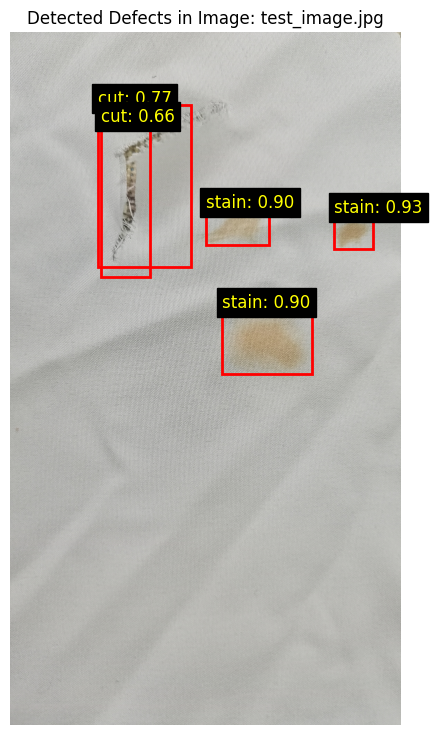

In [14]:
import torch
import torchvision.transforms as T
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from torchvision.models.detection import FasterRCNN

# ---------------------------------------
# Label Mapping
# ---------------------------------------
label_mapping = {
    1: "stain",
    2: "hole",
    3: "cut",
    4: "broken thread"
}

# ---------------------------------------
# Load Model
# ---------------------------------------
with torch.serialization.safe_globals([BackboneWithFPN, GeneralizedRCNNTransform, FasterRCNN]):
    model = torch.load("/content/fabric_defect_detector_finetuned_best.pth", map_location='cuda' if torch.cuda.is_available() else 'cpu', weights_only=False)
    model.eval()

# ---------------------------------------
# Load and Preprocess Image
# ---------------------------------------
def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)
    transform = T.ToTensor()
    return transform(image).unsqueeze(0), image  # add batch dimension, return both tensor and PIL

# ---------------------------------------
# Inference Function
# ---------------------------------------
def predict(image_path, threshold=0.5):
    image_tensor, original_image = load_image(image_path)
    image_tensor = image_tensor.to(device)

    with torch.no_grad():
        predictions = model(image_tensor)[0]

    boxes = predictions['boxes']
    labels = predictions['labels']
    scores = predictions['scores']

    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(original_image)

    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold:
            x_min, y_min, x_max, y_max = box.cpu().numpy()
            width, height = x_max - x_min, y_max - y_min
            rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            ax.text(x_min, y_min - 10, f"{label_mapping[label.item()]}: {score:.2f}",
                    color='yellow', fontsize=12, backgroundcolor="black")

    plt.axis('off')
    plt.title(f"Detected Defects in Image: {os.path.basename(image_path)}")
    plt.show()

# ---------------------------------------
# Test Image Path (update this)
# ---------------------------------------
test_image_path = "/content/test_image.jpg"  # <- change this to your test image path

# ---------------------------------------
# Run Prediction
# ---------------------------------------
predict(test_image_path, threshold=0.5)


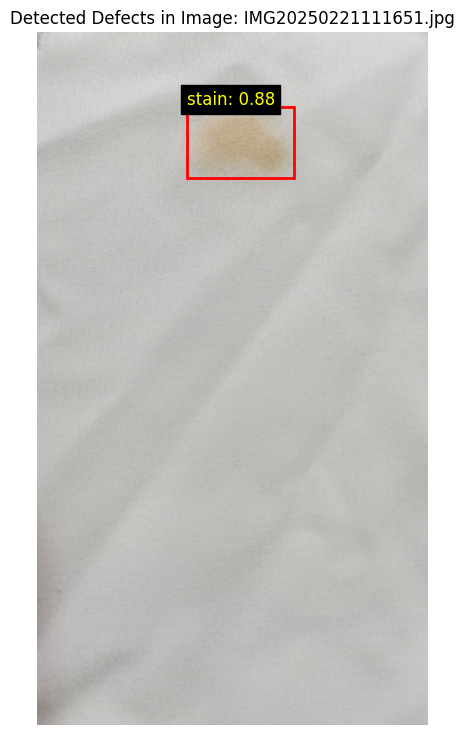

In [17]:
import torch
import torchvision.transforms as T
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from torchvision.models.detection import FasterRCNN

# ---------------------------------------
# Label Mapping
# ---------------------------------------
label_mapping = {
    1: "stain",
    2: "hole",
    3: "cut",
    4: "broken thread"
}

# ---------------------------------------
# Load Model
# ---------------------------------------
with torch.serialization.safe_globals([BackboneWithFPN, GeneralizedRCNNTransform, FasterRCNN]):
    model = torch.load("/content/fabric_defect_detector_finetuned_best.pth", map_location='cuda' if torch.cuda.is_available() else 'cpu', weights_only=False)
    model.eval()

# ---------------------------------------
# Load and Preprocess Image
# ---------------------------------------
def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)
    transform = T.ToTensor()
    return transform(image).unsqueeze(0), image  # add batch dimension, return both tensor and PIL

# ---------------------------------------
# Inference Function
# ---------------------------------------
def predict(image_path, threshold=0.5):
    image_tensor, original_image = load_image(image_path)
    image_tensor = image_tensor.to(device)

    with torch.no_grad():
        predictions = model(image_tensor)[0]

    boxes = predictions['boxes']
    labels = predictions['labels']
    scores = predictions['scores']

    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(original_image)

    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold:
            x_min, y_min, x_max, y_max = box.cpu().numpy()
            width, height = x_max - x_min, y_max - y_min
            rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            ax.text(x_min, y_min - 10, f"{label_mapping[label.item()]}: {score:.2f}",
                    color='yellow', fontsize=12, backgroundcolor="black")

    plt.axis('off')
    plt.title(f"Detected Defects in Image: {os.path.basename(image_path)}")
    plt.show()

# ---------------------------------------
# Test Image Path (update this)
# ---------------------------------------
test_image_path = "/content/drive/MyDrive/val/IMG20250221111651.jpg"  # <- change this to your test image path

# ---------------------------------------
# Run Prediction
# ---------------------------------------
predict(test_image_path, threshold=0.5)


In [4]:
import torch
import torchvision.transforms as T
import cv2
from PIL import Image
import os
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from torchvision.models.detection import FasterRCNN

# ---------------------------------------
# Label Mapping
# ---------------------------------------
label_mapping = {
    1: "stain",
    2: "hole",
    3: "cut",
    4: "broken thread"
}

# ---------------------------------------
# Device
# ---------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------------------
# Load Model
# ---------------------------------------
with torch.serialization.safe_globals([BackboneWithFPN, GeneralizedRCNNTransform, FasterRCNN]):
    model = torch.load("/content/fabric_defect_detector_finetuned_best.pth", map_location=device, weights_only=False)
    model.to(device)
    model.eval()

# ---------------------------------------
# Preprocess Frame
# ---------------------------------------
def preprocess_frame(frame):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(frame_rgb)
    transform = T.ToTensor()
    return transform(pil_image).unsqueeze(0), pil_image

# ---------------------------------------
# Annotate Frame
# ---------------------------------------
def annotate_frame(frame, predictions, threshold=0.5):
    boxes = predictions['boxes']
    labels = predictions['labels']
    scores = predictions['scores']

    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold:
            x_min, y_min, x_max, y_max = box.int().tolist()
            label_text = f"{label_mapping[label.item()]}: {score:.2f}"
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)
            cv2.putText(frame, label_text, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX,
                        0.6, (255, 255, 0), 2, cv2.LINE_AA)
    return frame

# ---------------------------------------
# Video Prediction
# ---------------------------------------
def predict_video(video_path, output_path, threshold=0.5):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        raise FileNotFoundError(f"Cannot open video: {video_path}")

    frame_width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps          = cap.get(cv2.CAP_PROP_FPS)

    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))
    print("🚀 Processing video...")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_tensor, _ = preprocess_frame(frame)
        frame_tensor = frame_tensor.to(device)

        with torch.no_grad():
            predictions = model(frame_tensor)[0]

        annotated = annotate_frame(frame.copy(), predictions, threshold)
        out.write(annotated)
        # Uncomment to display live (optional):
        # cv2.imshow('Defect Detection', annotated)
        # if cv2.waitKey(1) & 0xFF == ord('q'):
        #     break

    cap.release()
    out.release()
    cv2.destroyAllWindows()
    print(f"✅ Video saved to: {output_path}")

# ---------------------------------------
# Run on Test Video
# ---------------------------------------
input_video_path = "/content/vid2.mp4"         # 🔁 your test video
output_video_path = "/content/annotated_output_vid2.mp4"   # 📝 output path

predict_video(input_video_path, output_video_path, threshold=0.5)


🚀 Processing video...


error: OpenCV(4.11.0) /io/opencv/modules/highgui/src/window.cpp:1295: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'


In [5]:
import torch
import torchvision.transforms as T
import cv2
from PIL import Image
import os
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from torchvision.models.detection import FasterRCNN

# ---------------------------------------
# Label Mapping
# ---------------------------------------
label_mapping = {
    1: "stain",
    2: "hole",
    3: "cut",
    4: "broken thread"
}

# ---------------------------------------
# Device
# ---------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------------------
# Load Model
# ---------------------------------------
with torch.serialization.safe_globals([BackboneWithFPN, GeneralizedRCNNTransform, FasterRCNN]):
    model = torch.load("/content/fabric_defect_detector_finetuned_best.pth", map_location=device, weights_only=False)
    model.to(device)
    model.eval()

# ---------------------------------------
# Preprocess Frame
# ---------------------------------------
def preprocess_frame(frame):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(frame_rgb)
    transform = T.ToTensor()
    return transform(pil_image).unsqueeze(0), pil_image

# ---------------------------------------
# Annotate Frame
# ---------------------------------------
def annotate_frame(frame, predictions, threshold=0.5):
    boxes = predictions['boxes']
    labels = predictions['labels']
    scores = predictions['scores']

    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold:
            x_min, y_min, x_max, y_max = box.int().tolist()
            label_text = f"{label_mapping[label.item()]}: {score:.2f}"
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)
            cv2.putText(frame, label_text, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX,
                        0.6, (255, 255, 0), 2, cv2.LINE_AA)
    return frame

# ---------------------------------------
# Video Prediction
# ---------------------------------------
def predict_video(video_path, output_path, threshold=0.5):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        raise FileNotFoundError(f"Cannot open video: {video_path}")

    frame_width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps          = cap.get(cv2.CAP_PROP_FPS)

    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))
    print("🚀 Processing video...")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_tensor, _ = preprocess_frame(frame)
        frame_tensor = frame_tensor.to(device)

        with torch.no_grad():
            predictions = model(frame_tensor)[0]

        annotated = annotate_frame(frame.copy(), predictions, threshold)
        out.write(annotated)
        # Uncomment to display live (optional):
        # cv2.imshow('Defect Detection', annotated)
        # if cv2.waitKey(1) & 0xFF == ord('q'):
        #     break

    cap.release()
    out.release()
    #cv2.destroyAllWindows()
    print(f"✅ Video saved to: {output_path}")

# ---------------------------------------
# Run on Test Video
# ---------------------------------------
input_video_path = "/content/vid2.mp4"         # 🔁 your test video
output_video_path = "/content/annotated_output_vid2.mp4"   # 📝 output path

predict_video(input_video_path, output_video_path, threshold=0.5)


🚀 Processing video...
✅ Video saved to: /content/annotated_output_vid2.mp4


In [6]:
import torch
import torchvision.transforms as T
import cv2
from PIL import Image
import os
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from torchvision.models.detection import FasterRCNN

# ---------------------------------------
# Label Mapping
# ---------------------------------------
label_mapping = {
    1: "stain",
    2: "hole",
    3: "cut",
    4: "broken thread"
}

# ---------------------------------------
# Device
# ---------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------------------
# Load Model
# ---------------------------------------
with torch.serialization.safe_globals([BackboneWithFPN, GeneralizedRCNNTransform, FasterRCNN]):
    model = torch.load("/content/fabric_defect_detector_finetuned_best.pth", map_location=device, weights_only=False)
    model.to(device)
    model.eval()

# ---------------------------------------
# Preprocess Frame
# ---------------------------------------
def preprocess_frame(frame):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(frame_rgb)
    transform = T.ToTensor()
    return transform(pil_image).unsqueeze(0), pil_image

# ---------------------------------------
# Annotate Frame
# ---------------------------------------
def annotate_frame(frame, predictions, threshold=0.5):
    boxes = predictions['boxes']
    labels = predictions['labels']
    scores = predictions['scores']

    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold:
            x_min, y_min, x_max, y_max = box.int().tolist()
            label_text = f"{label_mapping[label.item()]}: {score:.2f}"
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)
            cv2.putText(frame, label_text, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX,
                        0.6, (255, 255, 0), 2, cv2.LINE_AA)
    return frame

# ---------------------------------------
# Video Prediction
# ---------------------------------------
def predict_video(video_path, output_path, threshold=0.5):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        raise FileNotFoundError(f"Cannot open video: {video_path}")

    frame_width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps          = cap.get(cv2.CAP_PROP_FPS)

    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))
    print("🚀 Processing video...")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_tensor, _ = preprocess_frame(frame)
        frame_tensor = frame_tensor.to(device)

        with torch.no_grad():
            predictions = model(frame_tensor)[0]

        annotated = annotate_frame(frame.copy(), predictions, threshold)
        out.write(annotated)
        # Uncomment to display live (optional):
        # cv2.imshow('Defect Detection', annotated)
        # if cv2.waitKey(1) & 0xFF == ord('q'):
        #     break

    cap.release()
    out.release()
    #cv2.destroyAllWindows()
    print(f"✅ Video saved to: {output_path}")

# ---------------------------------------
# Run on Test Video
# ---------------------------------------
input_video_path = "/content/vid3.mp4"         # 🔁 your test video
output_video_path = "/content/annotated_output_vid3.mp4"   # 📝 output path

predict_video(input_video_path, output_video_path, threshold=0.5)


🚀 Processing video...
✅ Video saved to: /content/annotated_output_vid3.mp4


In [8]:
import torch
import torchvision.transforms as T
import cv2
from PIL import Image
import os
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from torchvision.models.detection import FasterRCNN

# ---------------------------------------
# Label Mapping
# ---------------------------------------
label_mapping = {
    1: "stain",
    2: "hole",
    3: "cut",
    4: "broken thread"
}

# ---------------------------------------
# Device
# ---------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------------------
# Load Model
# ---------------------------------------
with torch.serialization.safe_globals([BackboneWithFPN, GeneralizedRCNNTransform, FasterRCNN]):
    model = torch.load("/content/fabric_defect_detector_finetuned_best.pth", map_location=device, weights_only=False)
    model.to(device)
    model.eval()

# ---------------------------------------
# Preprocess Frame
# ---------------------------------------
def preprocess_frame(frame):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(frame_rgb)
    transform = T.ToTensor()
    return transform(pil_image).unsqueeze(0), pil_image

# ---------------------------------------
# Annotate Frame
# ---------------------------------------
def annotate_frame(frame, predictions, threshold=0.5):
    boxes = predictions['boxes']
    labels = predictions['labels']
    scores = predictions['scores']

    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold:
            x_min, y_min, x_max, y_max = box.int().tolist()
            label_text = f"{label_mapping[label.item()]}: {score:.2f}"
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)
            cv2.putText(frame, label_text, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX,
                        0.6, (255, 255, 0), 2, cv2.LINE_AA)
    return frame

# ---------------------------------------
# Video Prediction
# ---------------------------------------
def predict_video(video_path, output_path, threshold=0.5):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        raise FileNotFoundError(f"Cannot open video: {video_path}")

    frame_width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps          = cap.get(cv2.CAP_PROP_FPS)

    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))
    print("🚀 Processing video...")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_tensor, _ = preprocess_frame(frame)
        frame_tensor = frame_tensor.to(device)

        with torch.no_grad():
            predictions = model(frame_tensor)[0]

        annotated = annotate_frame(frame.copy(), predictions, threshold)
        out.write(annotated)
        # Uncomment to display live (optional):
        # cv2.imshow('Defect Detection', annotated)
        # if cv2.waitKey(1) & 0xFF == ord('q'):
        #     break

    cap.release()
    out.release()
    #cv2.destroyAllWindows()
    print(f"✅ Video saved to: {output_path}")

# ---------------------------------------
# Run on Test Video
# ---------------------------------------
input_video_path = "/content/vid5.mp4"         # 🔁 your test video
output_video_path = "/content/annotated_output_vid5.mp4"   # 📝 output path

predict_video(input_video_path, output_video_path, threshold=0.5)


🚀 Processing video...
✅ Video saved to: /content/annotated_output_vid5.mp4


In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d sobouhiarif/new-rcnn-finetune
#kaggle datasets download -d sobouhiarif/fabric-defect-test

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1734, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


In [ ]:
# The following code will only execute
# successfully when compression is complete

import kagglehub

# Download latest version
path = kagglehub.dataset_download("sobouhiarif/new-rcnn-finetune")

print("Path to dataset files:", path)

KaggleApiHTTPError: 403 Client Error.

You don't have permission to access resource at URL: https://www.kaggle.com/datasets/sobouhiarif/new-rcnn-finetune. The server reported the following issues: Permission 'datasets.get' was denied
Please make sure you are authenticated if you are trying to access a private resource or a resource requiring consent.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
import pandas as pd
import cv2
from PIL import Image
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as T
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
from collections import defaultdict

# ---------------------------------------
# 0. Configuration
# ---------------------------------------
class Config:
    # Dataset paths (UPDATE THESE)
    TRAIN_CSV = "/content/labels_my-project-name_2025-02-27-11-52-06.csv"
    VAL_CSV = "/content/labels_my-project-name_2025-02-27-11-52-06.csv"
    IMG_DIR = "/content/drive/MyDrive/val"

    # Training parameters
    BATCH_SIZE = 4
    NUM_EPOCHS = 10
    LR = 0.0001
    WEIGHT_DECAY = 0.0005
    PATIENCE = 3  # for learning rate reduction

    # Model saving
    SAVE_DIR = "/content/models"
    SAVE_NAME = "fabric_defect_finetuned.pth"

    # Label mapping
    LABEL_MAPPING = {
        "stain": 1,
        "holes": 2,
        "cut": 3,
        "broken thread": 4
    }

config = Config()
num_classes = len(config.LABEL_MAPPING) + 1  # +1 for background

# ---------------------------------------
# 1. Device Setup
# ---------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# ---------------------------------------
# 2. Enhanced Dataset Class
# ---------------------------------------
class FabricDefectDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.image_names = self.annotations['image_name'].unique()

        # Validate labels
        self._validate_labels()

        # Data augmentation
        self.augmentation = T.Compose([
            T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomVerticalFlip(p=0.5)
        ])

    def _validate_labels(self):
        invalid_labels = set(self.annotations['label_name']) - set(config.LABEL_MAPPING.keys())
        if invalid_labels:
            raise ValueError(f"Invalid labels found: {invalid_labels}")

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = os.path.join(self.img_dir, image_name)

        # Load image
        try:
            image = cv2.imread(image_path)
            if image is None:
                raise FileNotFoundError(f"Image not found at {image_path}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = Image.fromarray(image)

            # Apply augmentations
            if self.transform and np.random.rand() > 0.5:
                image = self.augmentation(image)
        except Exception as e:
            print(f"Error loading image {image_path}: {str(e)}")
            # Return a random valid image if current one fails
            return self.__getitem__(np.random.randint(0, len(self)))

        # Get annotations
        records = self.annotations[self.annotations['image_name'] == image_name]
        boxes = []
        labels = []

        for _, row in records.iterrows():
            x_min = row['bbox_x']
            y_min = row['bbox_y']
            x_max = x_min + row['bbox_width']
            y_max = y_min + row['bbox_height']

            # Validate bounding box
            if x_max > x_min and y_max > y_min:
                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(config.LABEL_MAPPING[row['label_name']])

        # Skip if no valid boxes
        if not boxes:
            return self.__getitem__((idx + 1) % len(self))

        # Convert to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image = T.ToTensor()(image)

        return image, {"boxes": boxes, "labels": labels}

# ---------------------------------------
# 3. Load Datasets
# ---------------------------------------
def get_data_loaders():
    train_dataset = FabricDefectDataset(
        csv_file=config.TRAIN_CSV,
        img_dir=config.IMG_DIR,
        transform=True
    )

    val_dataset = FabricDefectDataset(
        csv_file=config.VAL_CSV,
        img_dir=config.IMG_DIR,
        transform=False
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=2,
        collate_fn=lambda x: tuple(zip(*x)),
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        collate_fn=lambda x: tuple(zip(*x)),
        pin_memory=True
    )

    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    return train_loader, val_loader

# ---------------------------------------
# 4. Model Setup
# ---------------------------------------
def create_model(pretrained=True):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT" if pretrained else None)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model.to(device)

# ---------------------------------------
# 5. Training Utilities
# ---------------------------------------
class MetricLogger:
    def __init__(self):
        self.metrics = defaultdict(float)
        self.count = 0

    def update(self, metrics_dict):
        for key, value in metrics_dict.items():
            self.metrics[key] += value
        self.count += 1

    def get_average(self):
        return {k: v / self.count for k, v in self.metrics.items()}

    def reset(self):
        self.metrics = defaultdict(float)
        self.count = 0

def save_checkpoint(model, optimizer, epoch, loss, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, path)

# ---------------------------------------
# 6. Training Loop
# ---------------------------------------
def train_model():
    model = create_model(pretrained=True)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.LR, weight_decay=config.WEIGHT_DECAY)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=config.PATIENCE)

    train_loader, val_loader = get_data_loaders()

    best_loss = float('inf')
    os.makedirs(config.SAVE_DIR, exist_ok=True)
    save_path = os.path.join(config.SAVE_DIR, config.SAVE_NAME)

    for epoch in range(config.NUM_EPOCHS):
        # Training phase
        model.train()
        train_logger = MetricLogger()

        for images, targets in train_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            losses.backward()
            optimizer.step()

            train_logger.update(loss_dict)
            train_logger.update({'total_loss': losses.item()})

        # Validation phase
        model.eval()
        val_logger = MetricLogger()

        with torch.no_grad():
            for images, targets in val_loader:
                images = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                try:
                    loss_dict = model(images, targets)
                    losses = sum(loss for loss in loss_dict.values())
                    val_logger.update(loss_dict)
                    val_logger.update({'total_loss': losses.item()})
                except Exception as e:
                    print(f"Validation error: {str(e)}")
                    continue

        # Print metrics
        train_metrics = train_logger.get_average()
        val_metrics = val_logger.get_average()

        print(f"\nEpoch {epoch+1}/{config.NUM_EPOCHS}")
        print("Train:", " | ".join([f"{k}: {v:.4f}" for k, v in train_metrics.items()]))
        print("Val:", " | ".join([f"{k}: {v:.4f}" for k, v in val_metrics.items()]))

        # Save best model
        val_loss = val_metrics.get('total_loss', float('inf'))
        if val_loss < best_loss:
            best_loss = val_loss
            save_checkpoint(model, optimizer, epoch, val_loss, save_path)
            print(f"Saved best model with val_loss: {best_loss:.4f}")

        # Adjust learning rate
        scheduler.step(val_loss)

    print("\nTraining completed!")
    print(f"Best model saved to: {save_path}")

# ---------------------------------------
# 7. Run Training
# ---------------------------------------
if __name__ == "__main__":
    train_model()

✅ Using device: cuda
Training samples: 58
Validation samples: 58
Error loading image /content/drive/MyDrive/val/IMG20250221111614.jpg: Image not found at /content/drive/MyDrive/val/IMG20250221111614.jpg
Error loading image /content/drive/MyDrive/val/IMG20250221115336.jpg: Image not found at /content/drive/MyDrive/val/IMG20250221115336.jpg
Error loading image /content/drive/MyDrive/val/IMG20250221111614.jpg: Image not found at /content/drive/MyDrive/val/IMG20250221111614.jpg
Validation error: 'list' object has no attribute 'values'
Validation error: 'list' object has no attribute 'values'
Validation error: 'list' object has no attribute 'values'
Validation error: 'list' object has no attribute 'values'
Validation error: 'list' object has no attribute 'values'
Validation error: 'list' object has no attribute 'values'
Validation error: 'list' object has no attribute 'values'
Validation error: 'list' object has no attribute 'values'
Validation error: 'list' object has no attribute 'values'

In [ ]:
import os
import torch
import pandas as pd
import cv2
from PIL import Image
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as T
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
from collections import defaultdict

# ---------------------------------------
# 0. Configuration
# ---------------------------------------
class Config:
    # Dataset paths (UPDATE THESE)
    TRAIN_CSV = "/content/labels_my-project-name_2025-02-27-11-52-06.csv"
    VAL_CSV = "/content/labels_my-project-name_2025-02-27-11-52-06.csv"
    IMG_DIR = "/content/drive/MyDrive/val"

    # Training parameters
    BATCH_SIZE = 4
    NUM_EPOCHS = 10
    LR = 0.0001
    WEIGHT_DECAY = 0.0005
    PATIENCE = 3  # for learning rate reduction

    # Model saving
    SAVE_DIR = "/content/models"
    SAVE_NAME = "fabric_defect_finetuned2.pth"

    # Label mapping
    LABEL_MAPPING = {
        "stain": 1,
        "holes": 2,
        "cut": 3,
        "broken thread": 4
    }

config = Config()
num_classes = len(config.LABEL_MAPPING) + 1  # +1 for background

# ---------------------------------------
# 1. Device Setup
# ---------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# ---------------------------------------
# 2. Enhanced Dataset Class
# ---------------------------------------
class FabricDefectDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.image_names = self.annotations['image_name'].unique()

        # Validate labels
        self._validate_labels()

        # Data augmentation
        self.augmentation = T.Compose([
            T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomVerticalFlip(p=0.5)
        ])

    def _validate_labels(self):
        invalid_labels = set(self.annotations['label_name']) - set(config.LABEL_MAPPING.keys())
        if invalid_labels:
            raise ValueError(f"Invalid labels found: {invalid_labels}")

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = os.path.join(self.img_dir, image_name)

        # Load image
        try:
            image = cv2.imread(image_path)
            if image is None:
                raise FileNotFoundError(f"Image not found at {image_path}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = Image.fromarray(image)

            # Apply augmentations
            if self.transform and np.random.rand() > 0.5:
                image = self.augmentation(image)
        except Exception as e:
            print(f"Error loading image {image_path}: {str(e)}")
            # Return a random valid image if current one fails
            return self.__getitem__(np.random.randint(0, len(self)))

        # Get annotations
        records = self.annotations[self.annotations['image_name'] == image_name]
        boxes = []
        labels = []

        for _, row in records.iterrows():
            x_min = row['bbox_x']
            y_min = row['bbox_y']
            x_max = x_min + row['bbox_width']
            y_max = y_min + row['bbox_height']

            # Validate bounding box
            if x_max > x_min and y_max > y_min:
                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(config.LABEL_MAPPING[row['label_name']])

        # Skip if no valid boxes
        if not boxes:
            return self.__getitem__((idx + 1) % len(self))

        # Convert to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image = T.ToTensor()(image)

        return image, {"boxes": boxes, "labels": labels}

# ---------------------------------------
# 3. Load Datasets
# ---------------------------------------
def get_data_loaders():
    train_dataset = FabricDefectDataset(
        csv_file=config.TRAIN_CSV,
        img_dir=config.IMG_DIR,
        transform=True
    )

    val_dataset = FabricDefectDataset(
        csv_file=config.VAL_CSV,
        img_dir=config.IMG_DIR,
        transform=False
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=2,
        collate_fn=lambda x: tuple(zip(*x)),
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        collate_fn=lambda x: tuple(zip(*x)),
        pin_memory=True
    )

    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    return train_loader, val_loader

# ---------------------------------------
# 4. Model Setup
# ---------------------------------------
def create_model(pretrained=True):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT" if pretrained else None)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model.to(device)

# ---------------------------------------
# 5. Training Utilities
# ---------------------------------------
class MetricLogger:
    def __init__(self):
        self.metrics = defaultdict(float)
        self.count = 0

    def update(self, metrics_dict):
        for key, value in metrics_dict.items():
            self.metrics[key] += value
        self.count += 1

    def get_average(self):
        return {k: v / self.count for k, v in self.metrics.items()}

    def reset(self):
        self.metrics = defaultdict(float)
        self.count = 0

def save_checkpoint(model, optimizer, epoch, loss, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, path)

# ---------------------------------------
# 6. Training Loop
# ---------------------------------------
def train_model():
    model = create_model(pretrained=True)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.LR, weight_decay=config.WEIGHT_DECAY)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=config.PATIENCE)

    train_loader, val_loader = get_data_loaders()

    best_loss = float('inf')
    os.makedirs(config.SAVE_DIR, exist_ok=True)
    save_path = os.path.join(config.SAVE_DIR, config.SAVE_NAME)

    for epoch in range(config.NUM_EPOCHS):
        # Training phase
        model.train()
        train_logger = MetricLogger()

        for images, targets in train_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            losses.backward()
            optimizer.step()

            train_logger.update(loss_dict)
            train_logger.update({'total_loss': losses.item()})

        # Validation phase
        model.eval()
        # Validation phase
        model.eval()
        val_logger = MetricLogger()

        with torch.no_grad():
            for images, targets in val_loader:
                images = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                try:
                    output = model(images, targets)

                    # Handle case where model returns list instead of dict
                    if isinstance(output, list):
                        print("Warning: Model returned list instead of dict, skipping batch")
                        continue

                    # Ensure we have a proper loss dictionary
                    if not isinstance(output, dict) or any(k not in output for k in ['loss_classifier', 'loss_box_reg']):
                        print("Warning: Invalid output format from model, skipping batch")
                        continue

                    losses = sum(loss for loss in output.values())
                    val_logger.update(output)
                    val_logger.update({'total_loss': losses.item()})
                except Exception as e:
                    print(f"Validation error: {str(e)}")
                    continue

        # Print metrics
        train_metrics = train_logger.get_average()
        val_metrics = val_logger.get_average()

        print(f"\nEpoch {epoch+1}/{config.NUM_EPOCHS}")
        print("Train:", " | ".join([f"{k}: {v:.4f}" for k, v in train_metrics.items()]))
        print("Val:", " | ".join([f"{k}: {v:.4f}" for k, v in val_metrics.items()]))

        # Save best model
        val_loss = val_metrics.get('total_loss', float('inf'))
        if val_loss < best_loss:
            best_loss = val_loss
            save_checkpoint(model, optimizer, epoch, val_loss, save_path)
            print(f"Saved best model with val_loss: {best_loss:.4f}")

        # Adjust learning rate
        scheduler.step(val_loss)

    print("\nTraining completed!")
    print(f"Best model saved to: {save_path}")

# ---------------------------------------
# 7. Run Training
# ---------------------------------------
if __name__ == "__main__":
    train_model()

✅ Using device: cuda
Training samples: 58
Validation samples: 58
Error loading image /content/drive/MyDrive/val/IMG20250221111614.jpg: Image not found at /content/drive/MyDrive/val/IMG20250221111614.jpg
Error loading image /content/drive/MyDrive/val/IMG20250221115336.jpg: Image not found at /content/drive/MyDrive/val/IMG20250221115336.jpg
Error loading image /content/drive/MyDrive/val/IMG20250221111614.jpg: Image not found at /content/drive/MyDrive/val/IMG20250221111614.jpg
Error loading image /content/drive/MyDrive/val/IMG20250221115336.jpg: Image not found at /content/drive/MyDrive/val/IMG20250221115336.jpg

Epoch 1/10
Train: loss_classifier: 0.1672 | loss_box_reg: 0.0544 | loss_objectness: 0.0724 | loss_rpn_box_reg: 0.0096 | total_loss: 0.3037
Val: 
Error loading image /content/drive/MyDrive/val/IMG20250221111614.jpg: Image not found at /content/drive/MyDrive/val/IMG20250221111614.jpg
Error loading image /content/drive/MyDrive/val/IMG20250221115336.jpg: Image not found at /content/d

In [ ]:
import os
import torch
import pandas as pd
import cv2
from PIL import Image
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as T
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
from collections import defaultdict

# ---------------------------------------
# 0. Configuration
# ---------------------------------------
class Config:
    TRAIN_CSV = "/content/labels_my-project-name_2025-02-27-11-52-06.csv"
    VAL_CSV = "/content/labels_my-project-name_2025-02-27-11-52-06.csv"
    IMG_DIR = "/content/drive/MyDrive/val"
    BATCH_SIZE = 4
    NUM_EPOCHS = 10
    LR = 0.0001
    WEIGHT_DECAY = 0.0005
    PATIENCE = 3
    SAVE_DIR = "/content/"
    SAVE_NAME = "fabric_defect_finetuned2.pth"
    LABEL_MAPPING = {
        "stain": 1,
        "holes": 2,
        "cut": 3,
        "broken thread": 4
    }

config = Config()
num_classes = len(config.LABEL_MAPPING) + 1  # +1 for background

# ---------------------------------------
# 1. Device Setup
# ---------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# ---------------------------------------
# 2. Dataset Class
# ---------------------------------------
class FabricDefectDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.image_names = self.annotations['image_name'].unique()
        self._validate_labels()
        self.augmentation = T.Compose([
            T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomVerticalFlip(p=0.5)
        ])

    def _validate_labels(self):
        invalid_labels = set(self.annotations['label_name']) - set(config.LABEL_MAPPING.keys())
        if invalid_labels:
            raise ValueError(f"Invalid labels found: {invalid_labels}")

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = os.path.join(self.img_dir, image_name)

        try:
            image = cv2.imread(image_path)
            if image is None:
                raise FileNotFoundError(f"Image not found at {image_path}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = Image.fromarray(image)
            if self.transform and np.random.rand() > 0.5:
                image = self.augmentation(image)
        except Exception as e:
            print(f"Error loading image {image_path}: {str(e)}")
            return self.__getitem__((idx + 1) % len(self))

        records = self.annotations[self.annotations['image_name'] == image_name]
        boxes = []
        labels = []

        for _, row in records.iterrows():
            x_min = row['bbox_x']
            y_min = row['bbox_y']
            x_max = x_min + row['bbox_width']
            y_max = y_min + row['bbox_height']
            if x_max > x_min and y_max > y_min:
                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(config.LABEL_MAPPING[row['label_name']])

        if not boxes:
            return self.__getitem__((idx + 1) % len(self))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image = T.ToTensor()(image)

        return image, {"boxes": boxes, "labels": labels}

# ---------------------------------------
# 3. Load Data
# ---------------------------------------
def get_data_loaders():
    train_dataset = FabricDefectDataset(config.TRAIN_CSV, config.IMG_DIR, transform=True)
    val_dataset = FabricDefectDataset(config.VAL_CSV, config.IMG_DIR, transform=False)

    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True,
                              num_workers=2, collate_fn=lambda x: tuple(zip(*x)), pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False,
                            num_workers=2, collate_fn=lambda x: tuple(zip(*x)), pin_memory=True)

    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    return train_loader, val_loader

# ---------------------------------------
# 4. Create Model
# ---------------------------------------
def create_model(pretrained=True):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT" if pretrained else None)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model.to(device)

# ---------------------------------------
# 5. Metric Logger
# ---------------------------------------
class MetricLogger:
    def __init__(self):
        self.metrics = defaultdict(float)
        self.count = 0

    def update(self, metrics_dict):
        for key, value in metrics_dict.items():
            self.metrics[key] += value
        self.count += 1

    def get_average(self):
        return {k: v / self.count for k, v in self.metrics.items()}

    def reset(self):
        self.metrics = defaultdict(float)
        self.count = 0

def save_checkpoint(model, optimizer, epoch, loss, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, path)

def load_model(model, path):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✅ Model loaded successfully from {path}")
    return model

# ---------------------------------------
# 6. Training Loop
# ---------------------------------------
def train_model():
    model = create_model(pretrained=True)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.LR, weight_decay=config.WEIGHT_DECAY)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=config.PATIENCE)

    train_loader, val_loader = get_data_loaders()

    best_loss = float('inf')
    os.makedirs(config.SAVE_DIR, exist_ok=True)
    save_path = os.path.join(config.SAVE_DIR, config.SAVE_NAME)

    for epoch in range(config.NUM_EPOCHS):
        model.train()
        train_logger = MetricLogger()

        for images, targets in train_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            losses.backward()
            optimizer.step()

            train_logger.update(loss_dict)
            train_logger.update({'total_loss': losses.item()})

        model.eval()
        val_logger = MetricLogger()

        with torch.no_grad():
            for images, targets in val_loader:
                images = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                try:
                    output = model(images, targets)
                    if isinstance(output, list):
                        continue
                    if not isinstance(output, dict) or any(k not in output for k in ['loss_classifier', 'loss_box_reg']):
                        continue

                    losses = sum(loss for loss in output.values())
                    val_logger.update(output)
                    val_logger.update({'total_loss': losses.item()})
                except Exception as e:
                    print(f"Validation error: {str(e)}")
                    continue

        train_metrics = train_logger.get_average()
        val_metrics = val_logger.get_average()

        print(f"\nEpoch {epoch+1}/{config.NUM_EPOCHS}")
        print("Train:", " | ".join([f"{k}: {v:.4f}" for k, v in train_metrics.items()]))
        print("Val:", " | ".join([f"{k}: {v:.4f}" for k, v in val_metrics.items()]))

        val_loss = val_metrics.get('total_loss', float('inf'))
        if val_loss < best_loss:
            best_loss = val_loss
            save_checkpoint(model, optimizer, epoch, val_loss, save_path)
            print(f"✅ Saved best model with val_loss: {best_loss:.4f}")

        scheduler.step(val_loss)

    print("\n🎯 Training completed!")
    print(f"📂 Best model saved to: {save_path}")

    # Confirm file saved
    if os.path.exists(save_path):
        print(f"✅ Confirmed: File {save_path} exists!")

        # Try reloading model
        reloaded_model = create_model(pretrained=False)  # Create same model architecture
        reloaded_model = load_model(reloaded_model, save_path)
        reloaded_model.eval()
    else:
        print(f"❌ Error: File {save_path} was not found!")

# ---------------------------------------
# 7. Run Training
# ---------------------------------------
if __name__ == "__main__":
    train_model()


✅ Using device: cuda
Training samples: 58
Validation samples: 58
Error loading image /content/drive/MyDrive/val/IMG20250221111614.jpg: Image not found at /content/drive/MyDrive/val/IMG20250221111614.jpg
Error loading image /content/drive/MyDrive/val/IMG20250221115336.jpg: Image not found at /content/drive/MyDrive/val/IMG20250221115336.jpg
Error loading image /content/drive/MyDrive/val/IMG20250221111614.jpg: Image not found at /content/drive/MyDrive/val/IMG20250221111614.jpg
Error loading image /content/drive/MyDrive/val/IMG20250221115336.jpg: Image not found at /content/drive/MyDrive/val/IMG20250221115336.jpg

Epoch 1/10
Train: loss_classifier: 0.1668 | loss_box_reg: 0.0726 | loss_objectness: 0.0547 | loss_rpn_box_reg: 0.0088 | total_loss: 0.3029
Val: 
Error loading image /content/drive/MyDrive/val/IMG20250221115336.jpg: Image not found at /content/drive/MyDrive/val/IMG20250221115336.jpg
Error loading image /content/drive/MyDrive/val/IMG20250221111614.jpg: Image not found at /content/d

In [ ]:
import os
import torch
import pandas as pd
import cv2
from PIL import Image
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as T
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
from collections import defaultdict

# ---------------------------------------
# 0. Configuration
# ---------------------------------------
class Config:
    TRAIN_CSV = "/content/labels_my-project-name_2025-02-27-11-52-06.csv"
    VAL_CSV = "/content/labels_my-project-name_2025-02-27-11-52-06.csv"
    IMG_DIR = "/content/drive/MyDrive/val"

    BATCH_SIZE = 4
    NUM_EPOCHS = 10
    LR = 0.0001
    WEIGHT_DECAY = 0.0005
    PATIENCE = 3

    SAVE_DIR = "/content/models"
    SAVE_NAME = "fabric_defect_finetuned2.pth"

    LABEL_MAPPING = {
        "stain": 1,
        "holes": 2,
        "cut": 3,
        "broken thread": 4
    }

config = Config()
num_classes = len(config.LABEL_MAPPING) + 1

# ---------------------------------------
# 1. Device Setup
# ---------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# ---------------------------------------
# 2. Dataset Class
# ---------------------------------------
class FabricDefectDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.image_names = self.annotations['image_name'].unique()
        self._validate_labels()

        self.augmentation = T.Compose([
            T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomVerticalFlip(p=0.5)
        ])

    def _validate_labels(self):
        invalid_labels = set(self.annotations['label_name']) - set(config.LABEL_MAPPING.keys())
        if invalid_labels:
            raise ValueError(f"Invalid labels found: {invalid_labels}")

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = os.path.join(self.img_dir, image_name)
        try:
            image = cv2.imread(image_path)
            if image is None:
                raise FileNotFoundError(f"Image not found at {image_path}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = Image.fromarray(image)
            if self.transform and np.random.rand() > 0.5:
                image = self.augmentation(image)
        except Exception as e:
            print(f"Error loading image {image_path}: {str(e)}")
            return self.__getitem__((idx + 1) % len(self))

        records = self.annotations[self.annotations['image_name'] == image_name]
        boxes, labels = [], []

        for _, row in records.iterrows():
            x_min = row['bbox_x']
            y_min = row['bbox_y']
            x_max = x_min + row['bbox_width']
            y_max = y_min + row['bbox_height']
            if x_max > x_min and y_max > y_min:
                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(config.LABEL_MAPPING[row['label_name']])

        if not boxes:
            return self.__getitem__((idx + 1) % len(self))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image = T.ToTensor()(image)

        return image, {"boxes": boxes, "labels": labels}

# ---------------------------------------
# 3. Data Loaders
# ---------------------------------------
def get_data_loaders():
    train_dataset = FabricDefectDataset(config.TRAIN_CSV, config.IMG_DIR, transform=True)
    val_dataset = FabricDefectDataset(config.VAL_CSV, config.IMG_DIR, transform=False)

    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))
    val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    return train_loader, val_loader

# ---------------------------------------
# 4. Model
# ---------------------------------------
def create_model(pretrained=True):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT" if pretrained else None)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model.to(device)

# ---------------------------------------
# 5. Utilities
# ---------------------------------------
class MetricLogger:
    def __init__(self):
        self.metrics = defaultdict(float)
        self.count = 0

    def update(self, metrics_dict):
        for key, value in metrics_dict.items():
            self.metrics[key] += value
        self.count += 1

    def get_average(self):
        return {k: v / self.count for k, v in self.metrics.items()}

    def reset(self):
        self.metrics = defaultdict(float)
        self.count = 0

def save_best_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(path):
    model = create_model(pretrained=False)
    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device)
    model.eval()
    return model

# ---------------------------------------
# 6. Training Loop
# ---------------------------------------
def train_model():
    model = create_model(pretrained=True)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.LR, weight_decay=config.WEIGHT_DECAY)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=config.PATIENCE)

    train_loader, val_loader = get_data_loaders()

    best_loss = float('inf')
    os.makedirs(config.SAVE_DIR, exist_ok=True)
    save_path = os.path.join(config.SAVE_DIR, config.SAVE_NAME)

    for epoch in range(config.NUM_EPOCHS):
        model.train()
        train_logger = MetricLogger()

        for images, targets in train_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            losses.backward()
            optimizer.step()

            train_logger.update(loss_dict)
            train_logger.update({'total_loss': losses.item()})

        model.eval()
        val_logger = MetricLogger()

        with torch.no_grad():
            for images, targets in val_loader:
                images = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                try:
                    loss_dict = model(images, targets)
                    losses = sum(loss for loss in loss_dict.values())

                    val_logger.update(loss_dict)
                    val_logger.update({'total_loss': losses.item()})
                except Exception as e:
                    print(f"Validation error: {str(e)}")
                    continue

        train_metrics = train_logger.get_average()
        val_metrics = val_logger.get_average()

        print(f"\nEpoch {epoch+1}/{config.NUM_EPOCHS}")
        print("Train:", " | ".join([f"{k}: {v:.4f}" for k, v in train_metrics.items()]))
        print("Val:", " | ".join([f"{k}: {v:.4f}" for k, v in val_metrics.items()]))

        val_loss = val_metrics.get('total_loss', float('inf'))
        if val_loss < best_loss:
            best_loss = val_loss
            save_best_model(model, save_path)
            print(f"✅ Saved best model at epoch {epoch+1} with val_loss: {best_loss:.4f}")

        scheduler.step(val_loss)

    print("\n🎯 Training completed!")
    print(f"📂 Best model saved to: {save_path}")

    # -------- Check & Load Best Model --------
    if os.path.exists(save_path):
        print(f"✅ File {save_path} exists.")
        loaded_model = load_model(save_path)
        print(f"✅ Loaded model successfully from {save_path}")
    else:
        print(f"❌ Error: File {save_path} was not found!")

# ---------------------------------------
# 7. Run Training
# ---------------------------------------
if __name__ == "__main__":
    train_model()


In [ ]:
import cv2
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as T
from google.colab.patches import cv2_imshow

def load_model_and_config(model_path, config_path):
    # Load config
    config = torch.load(config_path)
    label_mapping = config['label_mapping']
    num_classes = config['num_classes']
    reverse_label_mapping = {v: k for k, v in label_mapping.items()}

    # Create model architecture
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Load weights
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    return model, reverse_label_mapping

def predict_on_image(model, image_path, reverse_label_mapping, confidence_threshold=0.5):
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at {image_path}")

    original_image = image.copy()

    # Preprocess
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transform = T.Compose([T.ToTensor()])
    image_tensor = transform(Image.fromarray(image)).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        predictions = model(image_tensor)[0]

    # Draw results
    for box, label, score in zip(predictions['boxes'], predictions['labels'], predictions['scores']):
        if score > confidence_threshold:
            box = box.cpu().numpy().astype(int)
            label_name = reverse_label_mapping.get(label.item(), "unknown")

            # Draw bounding box
            cv2.rectangle(original_image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)

            # Put label
            text = f"{label_name} {score:.2f}"
            cv2.putText(original_image, text, (box[0], box[1]-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display
    print(f"Results for {os.path.basename(image_path)}:")
    cv2_imshow(cv2.resize(original_image, (800, 600)))

    return predictions

# Example usage:
if __name__ == "__main__":
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Paths to saved model files (update these)
    model_path = "/content/models/final_fabric_defect_finetuned2.pth"
    config_path = "/content/models/training_config.pth"
    test_image_path = "/content/test_image.jpg"  # Update this

    # Load model
    model, reverse_label_mapping = load_model_and_config(model_path, config_path)

    # Test prediction
    try:
        predictions = predict_on_image(model, test_image_path, reverse_label_mapping)

        # Print detailed results
        print("\nDetailed predictions:")
        for i, (box, label, score) in enumerate(zip(predictions['boxes'], predictions['labels'], predictions['scores'])):
            if score > 0.5:
                label_name = reverse_label_mapping.get(label.item(), "unknown")
                print(f"Detection {i+1}:")
                print(f"  Label: {label_name}")
                print(f"  Confidence: {score:.4f}")
                print(f"  BBox: {box.cpu().numpy().astype(int)}")
                print("-" * 40)
    except Exception as e:
        print(f"Error during prediction: {str(e)}")

FileNotFoundError: [Errno 2] No such file or directory: '/content/models/training_config.pth'